Давайте проанализируем данные опроса 4361 женщин из Ботсваны:

О каждой из них мы знаем:

    - сколько детей она родила (признак ceb)
    - возраст (age)
    - длительность получения образования (educ)
    - религиозная принадлежность (religion)
    - идеальное, по её мнению, количество детей в семье (idlnchld)
    - была ли она когда-нибудь замужем (evermarr)
    - возраст первого замужества (agefm)
    - длительность получения образования мужем (heduc)
    - знает ли она о методах контрацепции (knowmeth)
    - использует ли она методы контрацепции (usemeth)
    - живёт ли она в городе (urban)
    - есть ли у неё электричество, радио, телевизор и велосипед (electric, radio, tv, bicycle)

Давайте научимся оценивать количество детей по остальным признакам.

In [206]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

In [207]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [208]:
%ls

AUCs.txt        diamonds.txt  hw4.ipynb  hw8.ipynb       Untitled.ipynb
banknotes.txt   hw10.ipynb    hw5.ipynb  hw9.ipynb       water.txt
botswana.tsv    hw1.ipynb     hw6.ipynb  illiteracy.txt
challenger.txt  hw2.ipynb     hw7.ipynb  pines.txt


In [209]:
data = pd.read_csv("botswana.tsv", sep="\t", index_col=False, header = 0)

In [210]:
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0


In [211]:
religion = data.religion
religion.unique()

array(['catholic', 'protestant', 'spirit', 'other'], dtype=object)

Во многих признаках есть пропущенные значения. Сколько объектов из 4361 останется, если выбросить все, содержащие пропуски? 

In [212]:
print data.shape


(4361, 15)


In [213]:
data_clear = data.dropna()
print data_clear.shape
heduc = data.heduc
np.count_nonzero(~np.isnan(heduc))

(1834, 15)


1956

В разных признаках пропуски возникают по разным причинам и должны обрабатываться по-разному.

Например, в признаке agefm пропуски стоят только там, где evermarr=0, то есть, они соответствуют женщинам, никогда не выходившим замуж. Таким образом, для этого признака NaN соответствует значению "не применимо".

В подобных случаях, когда признак x1 на части объектов в принципе не может принимать никакие значения, рекомендуется поступать так:

    создать новый бинарный признак
    x2=1,x1='не применимо',0,иначе;
    заменить "не применимо" в x1 на произвольную константу c, которая среди других значений x1 не встречается.

Теперь, когда мы построим регрессию на оба признака и получим модель вида
y=β0+β1x1+β2x2,
на тех объектах, где x1 было измерено, регрессионное уравнение примет вид
y=β0+β1x,
а там, где x1 было "не применимо", получится
y=β0+β1c+β2.
Выбор c влияет только на значение и интерпретацию β2, но не β1.

Давайте используем этот метод для обработки пропусков в agefm и heduc.

    Создайте признак nevermarr, равный единице там, где в agefm пропуски.
    Удалите признак evermarr — в сумме с nevermarr он даёт константу, значит, в нашей матрице X будет мультиколлинеарность.
    Замените NaN в признаке agefm на cagefm=0.
    У объектов, где nevermarr = 1, замените NaN в признаке heduc на cheduc1=−1 (ноль использовать нельзя, так как он уже встречается у некоторых объектов выборки).

Сколько осталось пропущенных значений в признаке heduc?

In [214]:
data['newermarr'] = data['agefm'].apply(lambda x : 1 if math.isnan(x) else 0)
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle,newermarr
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0,0


In [215]:
data['agefm'] = data['agefm'].apply(lambda x : 0 if math.isnan(x) else x)
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle,newermarr
0,0,18,10,catholic,4.0,1.0,1.0,0,0.0,NaN,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,0,0.0,NaN,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0,0


In [216]:
data['heduc'] = map(lambda x, y: -1 if y == 1 else x , data['heduc'], data['newermarr'])
print data.shape[0] - np.count_nonzero(~np.isnan(data.heduc))
data = data.drop('evermarr', axis=1)

123


In [217]:
data.head()
print np.isnan(data.bicycle).values.ravel().sum()
print np.isnan(data.tv).values.ravel().sum()
print np.isnan(data.radio).values.ravel().sum()
print np.isnan(data.electric).values.ravel().sum()
print np.isnan(data.urban).values.ravel().sum()
print np.isnan(data.heduc).values.ravel().sum()
print np.isnan(data.agefm).values.ravel().sum()
print np.isnan(data.usemeth).values.ravel().sum()
print np.isnan(data.knowmeth).values.ravel().sum()
print np.isnan(data.idlnchld).values.ravel().sum()
#print np.isnan(data.religion).values.ravel().sum()
print np.isnan(data.educ).values.ravel().sum()
print np.isnan(data.age).values.ravel().sum()
print np.isnan(data.ceb).values.ravel().sum()
data.head()

3
2
2
3
0
123
0
71
7
120
0
0
0


,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,newermarr
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0


In [218]:
data['idlnchld_noans'] = data['idlnchld'].apply(lambda x : -1 if math.isnan(x) else x)
data['heduc_noans'] = data['heduc'].apply(lambda x : -2 if math.isnan(x) else x)
data['usemeth_noans'] = data['usemeth'].apply(lambda x : -1 if math.isnan(x) else x)

data['idlnchld'] = data['idlnchld'].apply(lambda x : 0 if math.isnan(x) else x)
data['heduc'] = data['heduc'].apply(lambda x : 0 if math.isnan(x) else x)
data['usemeth'] = data['usemeth'].apply(lambda x : 0 if math.isnan(x) else x)
#data['idlnchld_noans'] = map(lambda x, y: -1 if y == 1 else x , data['idlnchld'], data['newermarr'])
#data['heduc_noans'] = map(lambda x, y: -2 if y == 1 else x , data['heduc'], data['newermarr'])
#data['usemeth_noans'] = map(lambda x, y: -1 if y == 1 else x , data['usemeth'], data['newermarr'])
#data['idlnchld_noans'] = map(lambda x, y: -1 if math.isnan(x) else x , data['idlnchld'], data['idlnchld_noans'])
#data['heduc_noans'] = map(lambda x, y: -2 if math.isnan(x) else x , data['heduc'], data['idlnchld_noans'])
#data['usemeth_noans'] = map(lambda x, y: -1 if math.isnan(x) else x , data['usemeth'], data['idlnchld_noans'])

In [219]:
print np.count_nonzero(~np.isnan(data.idlnchld))

4361


In [220]:
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,newermarr,idlnchld_noans,heduc_noans,usemeth_noans
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,4.0,-1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0,2.0,14.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0,4.0,1.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,2.0,-1.0,0.0
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0,3.0,12.0,1.0


In [221]:
data = data.dropna(axis=0,how = 'any')

In [223]:
print data.shape[0]*data.shape[1], data.shape

78264 (4348, 18)


In [224]:
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,newermarr,idlnchld_noans,heduc_noans,usemeth_noans
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,4.0,-1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0,2.0,14.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0,4.0,1.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,2.0,-1.0,0.0
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0,3.0,12.0,1.0


In [226]:
m1 = smf.ols('ceb ~ age + educ + religion + idlnchld + knowmeth + usemeth +'\
                    'agefm + heduc + urban + electric + radio + tv +'\
             'bicycle + newermarr + idlnchld_noans + heduc_noans + usemeth_noans ', 
             data=data)
fitted = m1.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     412.5
Date:                Sun, 26 Jun 2016   Prob (F-statistic):               0.00
Time:                        15:44:38   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -1

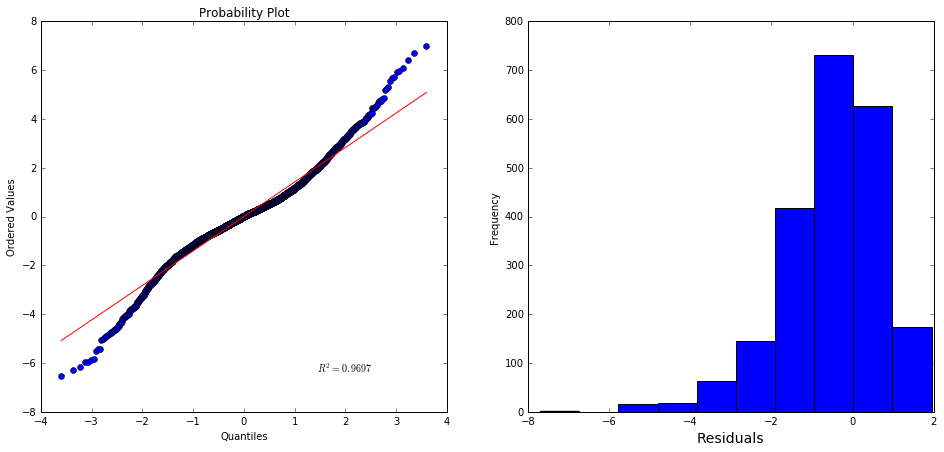

In [227]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

In [228]:
print 'Breusch-Pagan test: p=%e' % sms.het_breushpagan(fitted.resid, fitted.model.exog)[1]

Breusch-Pagan test: p=1.145293e-225


In [229]:
m2 = smf.ols('ceb ~ age + educ + religion + idlnchld + knowmeth + usemeth +'\
                    'agefm + heduc + urban + electric + radio + tv +'\
             'bicycle + newermarr + idlnchld_noans + heduc_noans + usemeth_noans ', 
             data=data)
fitted = m2.fit(cov_type='HC1')
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     345.0
Date:                Sun, 26 Jun 2016   Prob (F-statistic):               0.00
Time:                        15:45:26   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -1

In [230]:
print 'Breusch-Pagan test: p=%e' % sms.het_breushpagan(fitted.resid, fitted.model.exog)[1]

Breusch-Pagan test: p=1.145293e-225


In [231]:
m3 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + usemeth +'\
                    'agefm + heduc + urban + electric +'\
             'bicycle + newermarr + idlnchld_noans + heduc_noans + usemeth_noans ', 
             data=data)
fitted = m3.fit(cov_type='HC1')
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Sun, 26 Jun 2016   Prob (F-statistic):               0.00
Time:                        15:45:51   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.

In [232]:
print 'Breusch-Pagan test: p=%e' % sms.het_breushpagan(fitted.resid, fitted.model.exog)[1]

Breusch-Pagan test: p=1.119746e-228


In [234]:
print "F=%f, p=%f, k1=%f" % m2.fit().compare_f_test(m3.fit())

F=0.919236, p=0.467231, k1=5.000000


In [235]:
m4 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth  +'\
                    'agefm + heduc + urban + electric +'\
             'bicycle + newermarr + idlnchld_noans + heduc_noans', 
             data=data)
fitted = m4.fit(cov_type='HC1')
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     396.4
Date:                Sun, 26 Jun 2016   Prob (F-statistic):               0.00
Time:                        15:46:18   Log-Likelihood:                -7825.7
No. Observations:                4348   AIC:                         1.568e+04
Df Residuals:                    4335   BIC:                         1.576e+04
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -1.1931      0.262     -4.

In [236]:
sa = m3.fit().compare_f_test(m4.fit())

In [237]:
print sa

(92.890582301097112, 3.155200948040263e-40, 2.0)


In [238]:
print sms.het_breushpagan(fitted.resid, fitted.model.exog)[1]


2.48563622975e-219
